# Classification

## Dataset

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='datasets')
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
# Display one digit
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
print ('Label' , y[0])

Label 0


In [6]:
# Train and test sets
import numpy.random as rnd
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Shuffle data
shuffle_index = rnd.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier

In [7]:
y_train_5 =(y_train == 5)
y_test_5= (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([False])

In [10]:
# A personalized cross validation function
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
# Get representative samples
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95785
0.9684
0.96445


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87072585, 0.87649382, 0.89033355])

In [12]:
# Random classifier
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90825, 0.90915, 0.91155])

### Confusion matrix

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54101,   478],
       [ 1708,  3713]], dtype=int64)

#### Precision and recall

In [15]:
from sklearn.metrics import precision_score, recall_score
print('Precision = ', precision_score(y_train_5, y_train_pred))
print('Recall = ', recall_score(y_train_5,y_train_pred))

Precision =  0.8859460749224529
Recall =  0.6849289798930087


In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7725759467332501

#### Precision-recall tradeoff

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-10051.00182749])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [20]:
# Return decision scores (cross)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method = 'decision_function')

In [21]:
# Precision -  recall functions
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

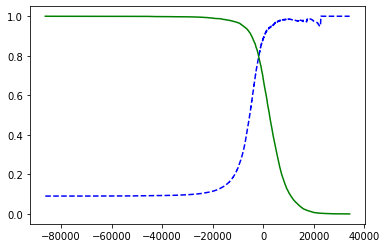

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [23]:
# Threshold 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.9000254388196388
0.6526471130787678


### The ROC curve

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

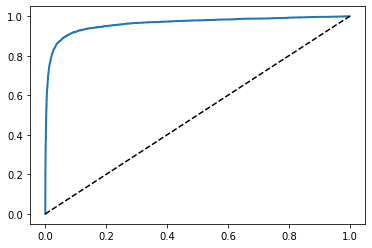

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)
plt.show()

In [26]:
## Compute AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9629891882003238

c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


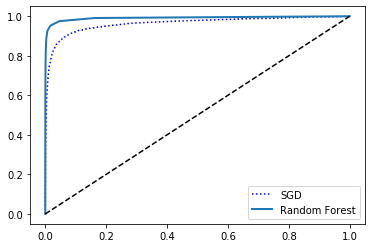

0.991609499609256


In [27]:
# Random forest ROC AUC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                    method = 'predict_proba')

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
print(roc_auc_score(y_train_5, y_scores_forest))

### Multiclass classification

In [28]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0], dtype=int8)

In [29]:
# One vs One classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=int8)

In [30]:
# Random forest
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
forest_clf.predict_proba([some_digit])

c:\users\alfa2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring="accuracy")

array([0.87072585, 0.87649382, 0.89033355])

### Error analysis

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5665,    0,   27,   15,    9,   56,   27,    3,  112,    9],
       [   2, 6207,   85,   39,   10,   24,   20,   55,  281,   19],
       [  63,   36, 5262,  105,   60,   43,   77,   64,  226,   22],
       [  48,   20,  194, 5116,   21,  354,   35,   42,  211,   90],
       [  18,   17,   62,   29, 5250,   20,   39,   15,  113,  279],
       [  91,   19,   72,  256,   93, 4152,  151,   15,  426,  146],
       [  56,    9,   90,    6,   56,  117, 5489,    2,   87,    6],
       [  24,   15,   71,  111,   96,   23,    4, 5470,   73,  378],
       [  52,   69,   93,  158,   55,  274,   37,   18, 4959,  136],
       [  29,   11,   32,  115,  205,   79,    1,  151,  145, 5181]],
      dtype=int64)

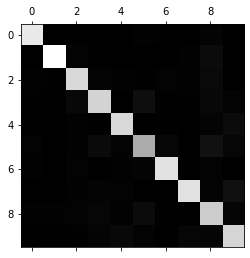

In [33]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

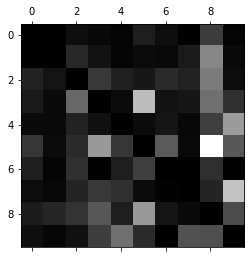

In [34]:
# Plot erro rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [35]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

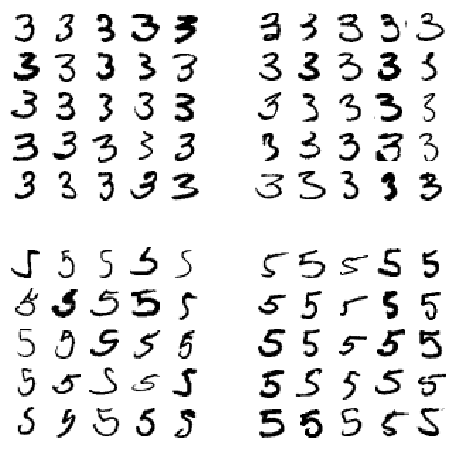

In [36]:
# Plot some examples
cl_a, cl_b = 3,5
X_aa =  X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab =  X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba =  X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb =  X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multioutput classification

In [37]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')